# FNC 6.4 Runge–Kutta
This notebook implements the coding parts of the RK section:
- Exercise 3: Modified Euler (ME2) and a convergence study on Exercise 1(a).
- Exercise 5: Heun's method and a convergence study on Exercise 1(a).
- Exercise 9: RK4 applied to a suite of IVPs (a–h).
- Exercise 10: Re-do Systems Exercise 6.3.4 (SIR model) with our RK4 instead of `solve`.
Implementation choices follow the FNC (Julia) style but are written in clean Python/Numpy.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ---- Generic stepper utilities ----
def _asarray(u):
    # ensure u is float or 1D numpy array; return ndarray view for arithmetic
    u = np.asarray(u, dtype=float)
    return u

def _rk_template(f, tspan, u0, n, stages):
    # Generic fixed-step RK driver.
    a, b = float(tspan[0]), float(tspan[1])
    h = (b - a) / n
    t = a + h*np.arange(n+1)
    u0 = _asarray(u0)
    m = u0.size
    U = np.empty((n+1, m), dtype=float)
    U[0] = u0
    for i in range(n):
        U[i+1] = stages(f, t[i], U[i], h)
    return t, U.squeeze()

# ---- Specific RK methods ----
def rk4(f, tspan, u0, n):
    # Classical RK4 (Function 6.4.4 analogue).
    def stages(f, ti, ui, h):
        k1 = f(ti, ui)
        k2 = f(ti + 0.5*h, ui + 0.5*h*np.asarray(k1))
        k3 = f(ti + 0.5*h, ui + 0.5*h*np.asarray(k2))
        k4 = f(ti + h,     ui + h*np.asarray(k3))
        return ui + (h/6.0)*(np.asarray(k1) + 2*np.asarray(k2) + 2*np.asarray(k3) + np.asarray(k4))
    return _rk_template(f, tspan, u0, n, stages)

def me2_modified_euler(f, tspan, u0, n):
    # Modified Euler (ME2), tableau:
    #   0  |
    #   1  | 1
    #  --- + --------
    #      | 1/2  1/2
    def stages(f, ti, ui, h):
        k1 = f(ti, ui)
        k2 = f(ti + h, ui + h*np.asarray(k1))
        return ui + 0.5*h*(np.asarray(k1) + np.asarray(k2))
    return _rk_template(f, tspan, u0, n, stages)

def heun(f, tspan, u0, n):
    # Heun's 2nd-order method (FNC variant), tableau:
    #   0  |
    #  2/3 | 2/3
    #  --- + --------
    #      | 1/4  3/4
    def stages(f, ti, ui, h):
        k1 = f(ti, ui)
        k2 = f(ti + (2.0/3.0)*h, ui + (2.0/3.0)*h*np.asarray(k1))
        return ui + h*(0.25*np.asarray(k1) + 0.75*np.asarray(k2))
    return _rk_template(f, tspan, u0, n, stages)

def loglog_with_ref(N, E, slope, title):
    plt.figure(figsize=(6,4))
    plt.loglog(N, E, marker='o', label='error @ final time')
    ref = E[-1]*(np.array(N)/N[-1])**(-slope)
    plt.loglog(N, ref, linestyle='--', label=f'O(n^{-{slope}})')
    plt.xlabel('n (time steps)')
    plt.ylabel('error')
    plt.title(title)
    plt.grid(True, which='both')
    plt.legend()
    plt.show()

## Exercise 3 — Modified Euler (ME2) on Exercise 1(a) and convergence study

TypeError: bad operand type for unary -: 'set'

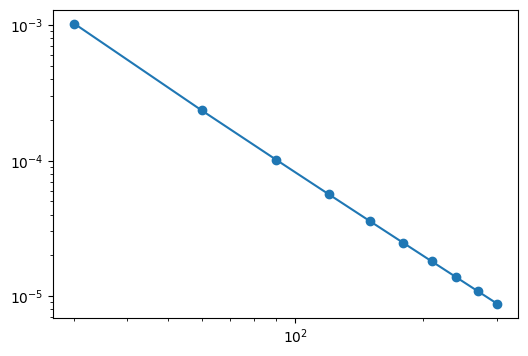

In [2]:
# IVP 1(a): u' = -2 t u, 0<=t<=2, u(0)=2, exact û=2e^{-t^2}
f = lambda t, u: -2.0*t*np.asarray(u)
u_exact = lambda t: 2.0*np.exp(-t**2)
a, b, u0 = 0.0, 2.0, 2.0

# reference using RK4 with very fine n
t_ref, u_ref = rk4(f, (a,b), u0, n=40000)
u_b_ref = u_ref[-1]

Ns = list(range(30, 301, 30))
errs = []
for n in Ns:
    t, u = me2_modified_euler(f, (a,b), u0, n)
    errs.append(abs(u[-1] - u_b_ref))

loglog_with_ref(Ns, errs, slope=2, title="Modified Euler on 1(a): error at t=2 vs n")
print("u_exact(2) ≈", u_exact(2.0), "  reference ≈", u_b_ref)

## Exercise 5 — Heun's method on Exercise 1(a) and convergence study

In [ ]:
errs = []
for n in Ns:
    t, u = heun(f, (a,b), u0, n)
    errs.append(abs(u[-1] - u_b_ref))

loglog_with_ref(Ns, errs, slope=2, title="Heun on 1(a): error at t=2 vs n")

## Exercise 9 — RK4 on problems (a)–(h)
For each: plot solution for n=300, then a log–log convergence plot using n=100,200,...,1000.

In [ ]:
def solve_and_error_rk4(f, span, u0, exact, nlist):
    errs = []
    for n in nlist:
        t, y = rk4(f, span, u0, n)
        # Handle scalar or vector solution
        y_end = y[-1][0] if np.asarray(y[-1]).ndim>0 else y[-1]
        errs.append(abs(exact(span[1]) - y_end))
    return errs

# (a) y'' + 9y = 9t, 0<t<2π, y(0)=1, y'(0)=1; ŷ(t) = t + cos(3t)
def f_a(t, U):
    y, yp = U
    return np.array([yp, 9.0*t - 9.0*y])
exact_a = lambda t: t + np.cos(3.0*t)
span_a, u0_a = (0.0, 2.0*math.pi), np.array([1.0, 1.0])

# (b) y'' + 9y = sin(2t), y(0)=2, y'(0)=1
def f_b(t, U):
    y, yp = U
    return np.array([yp, math.sin(2.0*t) - 9.0*y])
exact_b = lambda t: (1/5)*math.sin(3*t) + 2*math.cos(3*t) + (1/5)*math.sin(2*t)
span_b, u0_b = (0.0, 2.0*math.pi), np.array([2.0, 1.0])

# (c) y'' - 9y = 9t, 0<t<1, y(0)=2, y'(0)=-1
def f_c(t, U):
    y, yp = U
    return np.array([yp, 9.0*t + 9.0*y])
exact_c = lambda t: math.exp(3.0*t) + math.exp(-3.0*t) - t
span_c, u0_c = (0.0, 1.0), np.array([2.0, -1.0])

# (d) y'' + 4y' + 4y = t, 0<t<4, y(0)=1, y'(0)=3/4
def f_d(t, U):
    y, yp = U
    return np.array([yp, t - 4.0*yp - 4.0*y])
exact_d = lambda t: (3.0*t + 1.25)*math.exp(-2.0*t) + 0.25*(t - 1.0)
span_d, u0_d = (0.0, 4.0), np.array([1.0, 0.75])

# (e) x^2 y'' + 5 x y' + 4 y = 0 on 1<x<e^2, y(1)=1, y'(1)=-1
def f_e(x, U):
    y, yp = U
    return np.array([yp, -(5.0*x*yp + 4.0*y)/(x**2)])
exact_e = lambda x: (1.0 + math.log(x))/(x**2)
span_e, u0_e = (1.0, math.e**2), np.array([1.0, -1.0])

# (f) 2 x^2 y'' + 3 x y' - y = 0 on 1<x<16, y(1)=4, y'(1)=-1
def f_f(x, U):
    y, yp = U
    return np.array([yp, (y - 3.0*x*yp)/(2.0*x**2)])
exact_f = lambda x: 2.0*(math.sqrt(x) + 1.0/x)
span_f, u0_f = (1.0, 16.0), np.array([4.0, -1.0])

# (g) x^2 y'' - x y' + 2 y = 0 on 1<x<e^π, y(1)=3, y'(1)=4
def f_g(x, U):
    y, yp = U
    return np.array([yp, (x*yp - 2.0*y)/(x**2)])
exact_g = lambda x: x*(3.0*math.cos(math.log(x)) + math.sin(math.log(x)))
span_g, u0_g = (1.0, math.e**math.pi), np.array([3.0, 4.0])

# (h) x^2 y'' + 3 x y' + 4 y = 0 on e^{π/12} < x < e^π; y(a)=0, y'(a)=-6
def f_h(x, U):
    y, yp = U
    return np.array([yp, -(3.0*x*yp + 4.0*y)/(x**2)])
a = math.e**(math.pi/12.0)
span_h, u0_h = (a, math.e**math.pi), np.array([0.0, -6.0])
exact_h = lambda x: (3.0*math.cos(3.0*math.log(x)) + math.sin(3.0*math.log(x)))/x

problems = [
    ("(a)", f_a, span_a, u0_a, exact_a, "t"),
    ("(b)", f_b, span_b, u0_b, exact_b, "t"),
    ("(c)", f_c, span_c, u0_c, exact_c, "t"),
    ("(d)", f_d, span_d, u0_d, exact_d, "t"),
    ("(e)", f_e, span_e, u0_e, exact_e, "x"),
    ("(f)", f_f, span_f, u0_f, exact_f, "x"),
    ("(g)", f_g, span_g, u0_g, exact_g, "x"),
    ("(h)", f_h, span_h, u0_h, exact_h, "x"),
]

for tag, f, span, u0, exact, xlabel in problems:
    t, U = rk4(f, span, u0, n=300)
    y = U[:,0] if U.ndim>1 else U
    plt.figure(figsize=(6,4))
    plt.plot(t, y)
    plt.xlabel(xlabel); plt.ylabel('solution')
    plt.title(f"9 {tag} solution (RK4, n=300)")
    plt.grid(True)
    plt.show()

    nlist = list(range(100, 1001, 100))
    errs = solve_and_error_rk4(f, span, u0, exact, nlist)
    loglog_with_ref(nlist, errs, slope=4, title=f"9 {tag} RK4 final-time error vs n")

## Exercise 10 — Do Systems Exercise 6.3.4 with RK4 (replacing `solve`)

In [ ]:
# SIR-like 2D system from the Systems section (Exercise 6.3.4): 
#   v' = 0.2(1-v) - 3 v w,  w' = (3 v - 1) w,  v(0)=0.95, w(0)=0.05
def sir_rhs(t, U):
    v, w = U
    return np.array([0.2*(1.0 - v) - 3.0*v*w, (3.0*v - 1.0)*w])

t, VW = rk4(sir_rhs, (0.0, 200.0), np.array([0.95, 0.05]), n=8000)
v, w = VW[:,0], VW[:,1]

plt.figure(figsize=(6,4))
plt.plot(t, v, label="v(t) (susceptible)")
plt.plot(t, w, label="w(t) (infectious)")
plt.xlabel("t"); plt.ylabel("fraction"); plt.title("Exercise 10: SIR via RK4")
plt.grid(True); plt.legend(); plt.show()

print(f"Approx steady at t={t[-1]:.1f}: v≈{v[-1]:.6f}, w≈{w[-1]:.6f}")